## **Imports** 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## **Processing** 

In [9]:
diab_df=pd.read_csv('/Users/vladandreichuk/Desktop/Comparative-Analysis-of-ML-Algorithms-Predicting-Hospital-Readmission-of-Diabetes-Patients/CP_Hospital_Readmission/diab_df_filtered.csv')

In [4]:
diab_df.head(20)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted,outliers,outpatient,emergency
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,NO,False,0,0
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,No,Up,No,Ch,Yes,>30,False,0,0
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,Yes,NO,False,1,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,No,Up,No,Ch,Yes,NO,False,0,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,No,Steady,No,Ch,Yes,NO,False,0,0
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,...,No,No,Steady,No,No,Yes,>30,False,0,0
6,Caucasian,Male,[60-70),3,1,2,4,70,1,21,...,No,No,Steady,No,Ch,Yes,NO,False,0,0
7,Caucasian,Male,[70-80),1,1,7,5,73,0,12,...,No,No,No,No,No,Yes,>30,False,0,0
8,Caucasian,Female,[80-90),2,1,4,13,68,2,28,...,No,No,Steady,No,Ch,Yes,NO,False,0,0
9,Caucasian,Female,[90-100),3,3,4,12,33,3,18,...,No,No,Steady,No,Ch,Yes,NO,False,0,0


In [5]:
diab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   discharge_disposition_id  101766 non-null  int64 
 5   admission_source_id       101766 non-null  int64 
 6   time_in_hospital          101766 non-null  int64 
 7   num_lab_procedures        101766 non-null  int64 
 8   num_procedures            101766 non-null  int64 
 9   num_medications           101766 non-null  int64 
 10  number_inpatient          101766 non-null  int64 
 11  diag_1                    101766 non-null  object
 12  diag_2                    101766 non-null  object
 13  diag_3                    101766 non-null  object
 14  numb

### **Map Diag_ Columns**

In [10]:
def convert_to_float(data, col):
    # Convert the column to float, handling mixed values
    for i, value in enumerate(data[col]):
        try:
            data.at[i, col] = float(value)
        except ValueError:
            data.at[i, col] = float(-1)

    return data


diab_df = convert_to_float(diab_df, 'diag_1')
diab_df = convert_to_float(diab_df, 'diag_2')
diab_df = convert_to_float(diab_df, 'diag_3')


In [11]:
def assign_group(code):
    if 390 <= code <= 459 or code == 785:
        return 'Circulatory'
    elif 460 <= code <= 519 or code == 786:
        return 'Respiratory'
    elif 520 <= code <= 579 or code == 787:
        return 'Digestive'
    elif 250 <= code < 251:
        return 'Diabetes'
    elif 800 <= code <= 999:
        return 'Injury'
    elif 710 <= code <= 739 :
        return 'Musculoskeletal'
    elif 580 <= code <= 629 or code == 788 :
        return 'Genitourinary'
    elif 140 <= code <= 239:
        return 'Neoplasm'
    elif 780 <= code <= 781 or code == 784 or 790 <= code <= 799:
        return 'Neoplasm'
    elif 240 <= code <= 279:
        return 'Neoplasm'
    elif 680 <= code <= 709 or code == 782:
        return 'Neoplasm'
    elif 1 <= code <= 139:
        return 'Neoplasm'
    elif 290 <= code <= 319:
        return 'Neoplasm'
    else:
        return 'Other'

# Apply the function to 'diag_1', 'diag_2', and 'diag_3' columns
diab_df['diag_1'] = diab_df['diag_1'].map(assign_group)
diab_df['diag_2'] = diab_df['diag_2'].map(assign_group)
diab_df['diag_3'] = diab_df['diag_3'].map(assign_group)

In [8]:
diab_df['diag_1'].value_counts()

diag_1
Circulatory        30437
Neoplasm           16318
Respiratory        14423
Digestive           9475
Diabetes            8757
Injury              6974
Other               5308
Genitourinary       5117
Musculoskeletal     4957
Name: count, dtype: int64

### **Encode Columns**

In [12]:
col_names = diab_df.columns

In [13]:
# Define which columns should be one-hot encoded or ordinal encoded
one_hot_columns = ['race', 'gender','admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3',
       'max_glu_serum', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'outpatient', 'emergency']
ordinal_columns = ["age", 'outliers' ]

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,feature_name_combiner='concat'), one_hot_columns),
        ('ordinal', OrdinalEncoder(), ordinal_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified for encoding
)

# Apply the preprocessor to the data
diab_df= preprocessor.fit_transform(diab_df)


In [14]:
diab_df = pd.DataFrame(diab_df,columns=preprocessor.get_feature_names_out(col_names))

In [15]:
# Remove prefixes ending with '__'
diab_df.columns = [col.split('__')[-1] if '__' in col else col for col in diab_df.columns]

In [13]:
diab_df

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,admission_type_id_1,admission_type_id_2,...,emergency_1,age,outliers,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_inpatient,number_diagnoses,readmitted
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,41,0,1,0,1,NO
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,3,59,0,18,0,9,>30
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,2.0,0.0,2,11,5,13,1,6,NO
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,3.0,0.0,2,44,1,16,0,7,NO
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,4.0,0.0,1,51,0,8,0,5,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,7.0,0.0,3,51,0,16,0,9,>30
101762,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,8.0,0.0,5,33,3,18,1,9,NO
101763,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,7.0,0.0,1,53,0,9,0,13,NO
101764,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,8.0,0.0,10,45,2,21,1,9,NO


In [25]:
diab_df['readmitted'].value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

In [16]:
# Separate the target variable from the features
X_enc = diab_df.drop(columns=['readmitted'])  # Features
y = diab_df['readmitted']  # Target variable


# Encode target variable
def encode_targets(y):
    le = LabelEncoder()
    le.fit(y)
    y_enc = le.transform(y)
    return y_enc

# Transform y
y_enc = encode_targets(y)

### **Balance the Target**

In [17]:
# Resampling the minority class
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
X_enc_balanced, y_enc_balanced = sm.fit_resample(X_enc, y_enc)


### **Scaling and Splitting**

In [18]:
scaler = StandardScaler()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_enc_balanced, y_enc_balanced , test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Random Forest** 

### **Model** 

In [250]:
def rf_model(X, y, params, nsplits, scoring_metric):
    # Define a Random Forest model
    rf_model = RandomForestClassifier(random_state=42)

    # Perform grid search with stratified 10-fold cross-validation
    cv = StratifiedKFold(n_splits=nsplits)
    grid_search = GridSearchCV(rf_model, param_grid, cv=cv, scoring=scoring_metric)

    # Fit the model within the loop
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_

    # Train the Random Forest model with the best hyperparameters
    best_rf_model = RandomForestClassifier(**best_params, random_state=42)

    # Fit the model within the loop
    best_rf_model.fit(X_train, y_train)

    return grid_search, best_rf_model


# Set up a grid of hyperparameters to search
param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30, 50]
    }


rf_gs, best_rf_model = rf_model(X_train, y_train, params = param_grid , nsplits = 10, scoring_metric = 'f1_weighted')



### **Predictions and Evaluation** 

In [252]:
rf_gs.best_params_

{'max_depth': 50, 'n_estimators': 300}

In [ ]:
# Make predictions and evaluate the KNN model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")

    confusion_matrix_result = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NO', '>30','<30'], yticklabels=['NO', '>30','<30'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return y_pred, y_pred_prob , [accuracy,precision,recall,f1,roc_auc]

In [ ]:
y_pred_rf, y_pred_prob_rf, rf_metrics_list = evaluate_model(rf_gs, X_test, y_test)

In [251]:
# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

In [253]:
y_pred_prob= best_rf_model.predict_proba(X_test)

In [254]:
# Evaluate the model and compute various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test, y_pred,average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob,multi_class='ovr')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")


Accuracy: 0.71
Precision: 0.73
Recall: 0.71
F1 Score: 0.70
ROC-AUC: 0.85


In [255]:
# Create a confusion matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred)
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NO', '>30','<30'], yticklabels=['NO', '>30','<30'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix:
[[8896  780 1386]
 [  51 2458 4550]
 [  23 1750 9161]]


## **Naive Bayes** 

### **Model** 

In [20]:
def nb_model(X, y, nsplits):
    # Define a Gaussian Naive Bayes model
    nb_model = GaussianNB()

    # Perform stratified k-fold cross-validation
    cv = StratifiedKFold(n_splits=nsplits)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores=[]

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train the Gaussian Naive Bayes model
        nb_model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = nb_model.predict(X_test)
        y_pred_prob= nb_model.predict_proba(X_test)

        # Evaluate the model and compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_test, y_pred_prob,multi_class='ovr')

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

    # Calculate the average scores across all folds
    avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)
    avg_auc = sum(roc_auc_scores) / len(roc_auc_scores)

    return nb_model,avg_accuracy, avg_precision, avg_recall, avg_f1, avg_auc


### **Predictions and Evaluation** 

In [21]:
nb_model,avg_accuracy, avg_precision, avg_recall, avg_f1, avg_auc = nb_model(X_train, y_train, nsplits=10)

print(f"Average CV Accuracy: {avg_accuracy:.2f}")
print(f"Average CV Precision: {avg_precision:.2f}")
print(f"Average CV Recall: {avg_recall:.2f}")
print(f"Average CV F1 Score: {avg_f1:.2f}")
print(f"Average CV ROC-AUC: {avg_auc:.2f}")

Average Accuracy: 0.40
Average Precision: 0.56
Average Recall: 0.40
Average F1 Score: 0.27
ROC-AUC: 0.60


In [ ]:
y_pred_nb, y_pred_prob_nb, snb_metrics_list = evaluate_model(nb_model, X_test, y_test)

In [22]:
# Make predictions on the test set
y_pred = nb_model.predict(X_test)
y_pred_prob= nb_model.predict_proba(X_test)
# Evaluate the model and compute various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test, y_pred,average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob,multi_class='ovr')

print(f"Accuracy Test: {accuracy:.2f}")
print(f"Precision Test: {precision:.2f}")
print(f"Recall Test: {recall:.2f}")
print(f"F1 Score Test: {f1:.2f}")
print(f"ROC-AUC Test: {roc_auc:.2f}")


Accuracy: 0.40
Precision: 0.57
Recall: 0.40
F1 Score: 0.27
ROC-AUC: 0.61


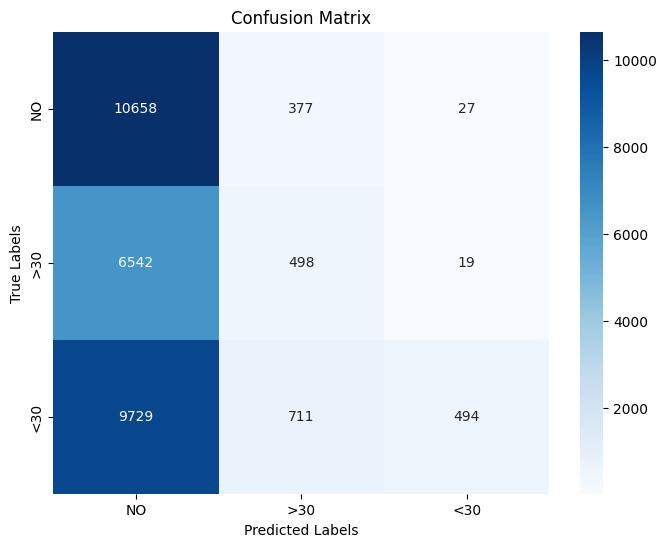

In [26]:
# Create a confusion matrix
confusion_matrix_result_nb= confusion_matrix(y_test, y_pred)
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NO', '>30','<30'], yticklabels=['NO', '>30','<30'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## **SVM** 

In [28]:
def svm_model(X, y, params, nsplits, scoring_metric):
    # Define an SVM model
    svm_model = SVC(random_state=42)

    # Perform grid search with stratified 10-fold cross-validation
    cv = StratifiedKFold(n_splits=nsplits)
    grid_search = GridSearchCV(svm_model, param_grid, cv=cv, scoring=scoring_metric)

    # Fit the model within the loop
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_

    # Train the SVM model with the best hyperparameters
    best_svm_model = SVC(**best_params, random_state=42)

    # Fit the model within the loop
    best_svm_model.fit(X_train, y_train)

    return grid_search, best_svm_model

# Set up a grid of hyperparameters to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
}

svm_gs, best_svm_model = svm_model(X_train, y_train, params=param_grid, nsplits=10, scoring_metric='f1_weighted')

### **Predictions and Evaluation** 

In [ ]:
svm_gs.best_params_

In [ ]:
y_pred_svm, y_pred_prob_svm, svm_metrics_list = evaluate_model(svm_gs, X_test, y_test)

In [ ]:

# Make predictions on the test set
y_pred_svm = best_svm_model.predict(X_test)
y_pred_prob_svm= best_rf_model.predict_proba(X_test)

# Evaluate the model and compute various metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
roc_auc_svm = roc_auc_score(y_test, y_pred_prob_svm,multi_class='ovr')


print(f"Accuracy: {accuracy_svm:.2f}")
print(f"Precision: {precision_svm:.2f}")
print(f"Recall: {recall_svm:.2f}")
print(f"F1 Score: {f1_svm:.2f}")
print(f"ROC-AUC: {roc_auc_svm:.2f}")


In [ ]:
# Create a confusion matrix
confusion_matrix_result_svm = confusion_matrix(y_test, y_pred_svm)
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NO', '>30','<30'], yticklabels=['NO', '>30','<30'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SVM)')
plt.show()

## **K-Nearest Neighbours** 

### **Model** 

In [19]:
# Create and train the K-nearest neighbors model
def knn_model(X, y, params, nsplits, scoring_metric):
    knn_model = KNeighborsClassifier()

    cv = StratifiedKFold(n_splits=nsplits)
    grid_search = GridSearchCV(knn_model, param_grid, cv=cv, scoring=scoring_metric)

    grid_search.fit(X, y)

    best_params = grid_search.best_params_

    best_knn_model = KNeighborsClassifier(**best_params)
    best_knn_model.fit(X, y)

    return grid_search, best_knn_model

# Set up a grid of hyperparameters to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

knn_gs, best_knn_model = knn_model(X_train, y_train, params=param_grid, nsplits=10, scoring_metric='f1_weighted')

### **Predictions and Evaluation** 

In [ ]:
# Make predictions and evaluate the K-nearest neighbors model
knn_gs.best_params_

In [ ]:
y_pred_knn, y_pred_prob_knn, knn_metrics_list = evaluate_model(knn_gs, X_test, y_test)

In [ ]:
y_pred_knn = best_knn_model.predict(X_test)
y_pred_prob_knn = best_knn_model.predict_proba(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
roc_auc_knn = roc_auc_score(y_test, y_pred_prob_knn, multi_class='ovr')

print(f"Accuracy: {accuracy_knn:.2f}")
print(f"Precision: {precision_knn:.2f}")
print(f"Recall: {recall_knn:.2f}")
print(f"F1 Score: {f1_knn:.2f}")
print(f"ROC-AUC: {roc_auc_knn:.2f}")

# Create a confusion matrix
confusion_matrix_result_knn = confusion_matrix(y_test, y_pred_knn)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NO', '>30', '<30'], yticklabels=['NO', '>30', '<30'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (K-nearest Neighbors)')
plt.show()

## **XGBoost** 

## **AdaBoost** 

## **CNN** 